# Multi Label Classification: Auto Tagging

Importing required Libraries

In [1]:
import re

import joblib
import nltk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

Loading Dataset

In [62]:
dataset = pd.read_excel('Sample_AutoTagging_Data_Confidential.xlsx')
dataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,"Climate risk and response: Physical hazards and socioeconomic impacts - While we attempt to draw out qualitatively (and, to the extent possible, quantitatively) the knock-on effects from direct physical impacts of climate change, we recognize the limitations of this exercise given the complexity of socioeconomic systems.The nine distinct cases of physical climate risk in various geographies and sectors that we examine, including direct impact and knock-on effects, as well as adaptation costs and strategies, help illustrate the specific socioeconomic impact of the different physical climate hazards on the examined human, physical, or natural system (Exhibit 5).Specifically, we looked at the impact of climate change on livability and workability in India and the Mediterranean; disruption of food systems through looking at global breadbaskets and African agriculture; physical asset destruction in residential real estate in Florida and in supply chains for semiconductors and heavy rare earth metals; disruption of five types of infrastructure services and, in particular, the threat of flooding to urban areas; and destruction of natural capital through impacts on glaciers, oceans, and forests.While our case studies illustrate the localized impacts of a changing climate, rising temperatures are a global trend and we assess how physical climate hazards could evolve in 105 countries.",Risk & Resilience|Strategy & Corporate Finance|Agriculture|Operations|Sustainability,Sustainability - Climate & ESG Mgmt|Government-Regulatory-External Affairs|Agricultural produce trading & processing|Non-Financial Risk & Compliance|Manufacturing & supply chain|Sustainability strategy & portfolio|Sustainability investing|Green business building
1,"New Accenture Research Finds Leaders and Employees Hold Differing Views on Progress Toward Equality - Closing the gap will yield substantial benefits for companies and their employees.The report, “ Getting to Equal 2020: The Hidden Value of Culture Makers ,” which includes research across 28 countries, found that organizations are at an inflection point: Today’s workforce cares increasingly about workplace culture and believes it is critical to helping them thrive in the workplace (reported by 77% of women and 67% of men), and a majority of leaders (68%) believe an inclusive workplace culture is vital to the success of their business.At the same time, there is a perception gap: Two thirds of leaders (68%) feel they create empowering environments where people have a sense of belonging, yet just one third (36%) of employees agree.Everyone — both women and men — would advance faster, and global profits would increase by US$3.7 trillion.If the gap were closed by half:The research is especially timely for leaders, as employee expectations are only set to increase: It found that a larger percentage of Gen Z is more concerned with workplace culture than Boomers (75% vs.They are more likely to lead organizations where people advance, focus on innovation and remain committed — and their organizations’ profits are nearly three times higher than those of their peers.The report lays out steps to help close perception gaps and drive progress toward a more equal culture that benefits everyone and enables leaders to continuously evolve their strategies to meet changing needs.The research reaffirms that bold leadership, comprehensive action and an empowering environment are proven anchors for creating a culture of equality:Read the global report at: accenture.com/gettingtoequal Building on previous Accenture research that has explored how to build a workplace culture of equality and the benefits for organizations and employees, the report is based on a global survey of more than 30,000 professionals in 28 countries; a survey of more than 1,700 senior executives; and a model that combines employee survey results with published labor force data.",Organization,Talent|Culture & transformationa

Dataset Information

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SUMMARY        20000 non-null  object
 1   PRACTICE/AREA  20000 non-null  object
 2   SL/SUB-AREA    20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


Dataset Statistics

In [4]:
dataset.describe()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
count,20000,20000,20000
unique,19985,5910,12637
top,Survey: US consumer sentiment during the coron...,Organization,Economic development
freq,3,1034,347


### Data-Preprocessing

In [5]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [6]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    # Lower case
    document = document.lower()

    # Remove punctuation and numbers
    document = re.sub(r'[^\w\s]', '', document)
    document = re.sub(r'\d+', '', document)

    # Tokenize
    tokens = word_tokenize(document)

    # Remove duplicate words
    tokens = list(set(tokens))

    # Remove stopwords, Lemmatize, and then rejoin the words
    wordsLemmatized = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    document = " ".join(wordsLemmatized)
    return document

In [7]:
dataset['SUMMARY'] = dataset['SUMMARY'].apply(preprocess_text)
dataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,urban ocean risk study qualitatively semicondu...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,would concerned result faster view comprehensi...,Organization,Talent|Culture & transformational change
2,supply widespread adjust work covid life broug...,"Growth, Marketing & Sales",Customer experience
3,fight vaccine normal sight next define trend e...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,global report entirely reality quickly opportu...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...


nlp = spacy.load('en_core_web_sm')


def preprocess_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

dataset['SUMMARY'] = dataset['SUMMARY'].apply(preprocess_spacy)
dataset.head()

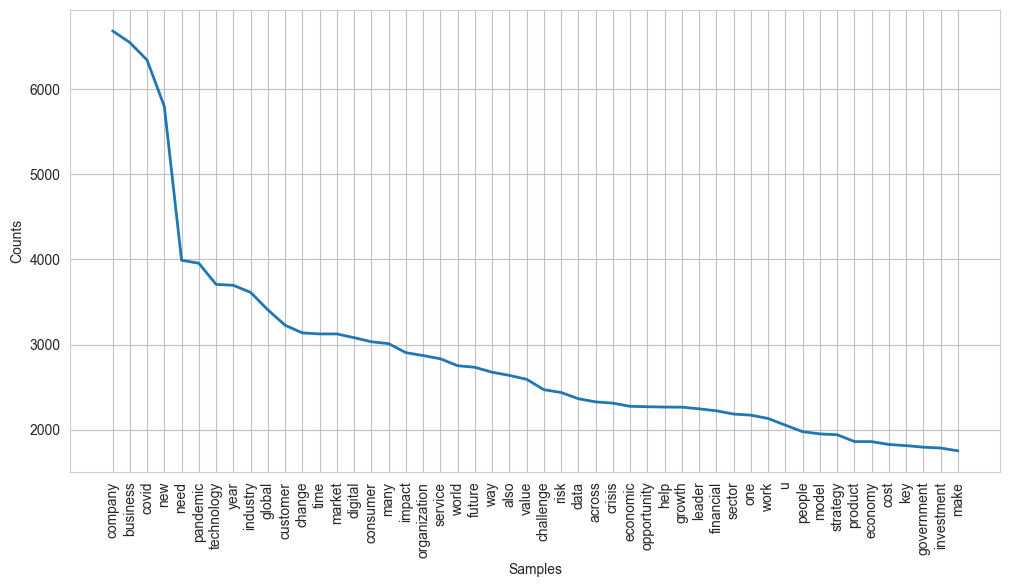

Total Words Count:  934603


In [8]:
corpus = ' '.join(dataset['SUMMARY'])

tokens = nltk.word_tokenize(corpus)

fdist = FreqDist(tokens)

plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()
print('Total Words Count: ', len(tokens))

In [63]:
dataset['PRACTICE/AREA'] = dataset['PRACTICE/AREA'].str.split('|')
dataset['SL/SUB-AREA'] = dataset['SL/SUB-AREA'].str.split('|')
dataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,"Climate risk and response: Physical hazards and socioeconomic impacts - While we attempt to draw out qualitatively (and, to the extent possible, quantitatively) the knock-on effects from direct physical impacts of climate change, we recognize the limitations of this exercise given the complexity of socioeconomic systems.The nine distinct cases of physical climate risk in various geographies and sectors that we examine, including direct impact and knock-on effects, as well as adaptation costs and strategies, help illustrate the specific socioeconomic impact of the different physical climate hazards on the examined human, physical, or natural system (Exhibit 5).Specifically, we looked at the impact of climate change on livability and workability in India and the Mediterranean; disruption of food systems through looking at global breadbaskets and African agriculture; physical asset destruction in residential real estate in Florida and in supply chains for semiconductors and heavy rare earth metals; disruption of five types of infrastructure services and, in particular, the threat of flooding to urban areas; and destruction of natural capital through impacts on glaciers, oceans, and forests.While our case studies illustrate the localized impacts of a changing climate, rising temperatures are a global trend and we assess how physical climate hazards could evolve in 105 countries.","[Risk & Resilience, Strategy & Corporate Finance, Agriculture, Operations, Sustainability]","[Sustainability - Climate & ESG Mgmt, Government-Regulatory-External Affairs, Agricultural produce trading & processing, Non-Financial Risk & Compliance, Manufacturing & supply chain, Sustainability strategy & portfolio, Sustainability investing, Green business building]"
1,"New Accenture Research Finds Leaders and Employees Hold Differing Views on Progress Toward Equality - Closing the gap will yield substantial benefits for companies and their employees.The report, “ Getting to Equal 2020: The Hidden Value of Culture Makers ,” which includes research across 28 countries, found that organizations are at an inflection point: Today’s workforce cares increasingly about workplace culture and believes it is critical to helping them thrive in the workplace (reported by 77% of women and 67% of men), and a majority of leaders (68%) believe an inclusive workplace culture is vital to the success of their business.At the same time, there is a perception gap: Two thirds of leaders (68%) feel they create empowering environments where people have a sense of belonging, yet just one third (36%) of employees agree.Everyone — both women and men — would advance faster, and global profits would increase by US$3.7 trillion.If the gap were closed by half:The research is especially timely for leaders, as employee expectations are only set to increase: It found that a larger percentage of Gen Z is more concerned with workplace culture than Boomers (75% vs.They are more likely to lead organizations where people advance, focus on innovation and remain committed — and their organizations’ profits are nearly three times higher than those of their peers.The report lays out steps to help close perception gaps and drive progress toward a more equal culture that benefits everyone and enables leaders to continuously evolve their strategies to meet changing needs.The research reaffirms that bold leadership, comprehensive action and an empowering environment are proven anchors for creating a culture of equality:Read the global report at: accenture.com/gettingtoequal Building on previous Accenture research that has explored how to build a workplace culture of equality and the benefits for organizations and employees, the report is based on a global survey of more than 30,000 professionals in 28 countries; a survey of more than 1,700 senior executives; and a model that combines employee survey results with published labor force data.",[Organization],"[Talent, C

In [64]:
mlb = MultiLabelBinarizer()
binarizedLabels1 = mlb.fit_transform(dataset['PRACTICE/AREA'])
binarizedLabels1 = pd.DataFrame(binarizedLabels1, columns=mlb.classes_)
binarizedLabels1.head()

,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,Digital & Analytics (DnA),...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
dataset = pd.concat([dataset, binarizedLabels1], axis=1)
dataset.drop('PRACTICE/AREA', axis=1, inplace=True)
dataset.head()

,SUMMARY,SL/SUB-AREA,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,urban ocean risk study qualitatively semicondu...,"[Sustainability - Climate & ESG Mgmt, Governme...",0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,would concerned result faster view comprehensi...,"[Talent, Culture & transformational change]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,supply widespread adjust work covid life broug...,[Customer experience],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,fight vaccine normal sight next define trend e...,"[Economic development, Crisis Preparedness and...",0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,0
4,global report entirely reality quickly opportu...,"[Tech strategy & operating model & agile, Lead...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


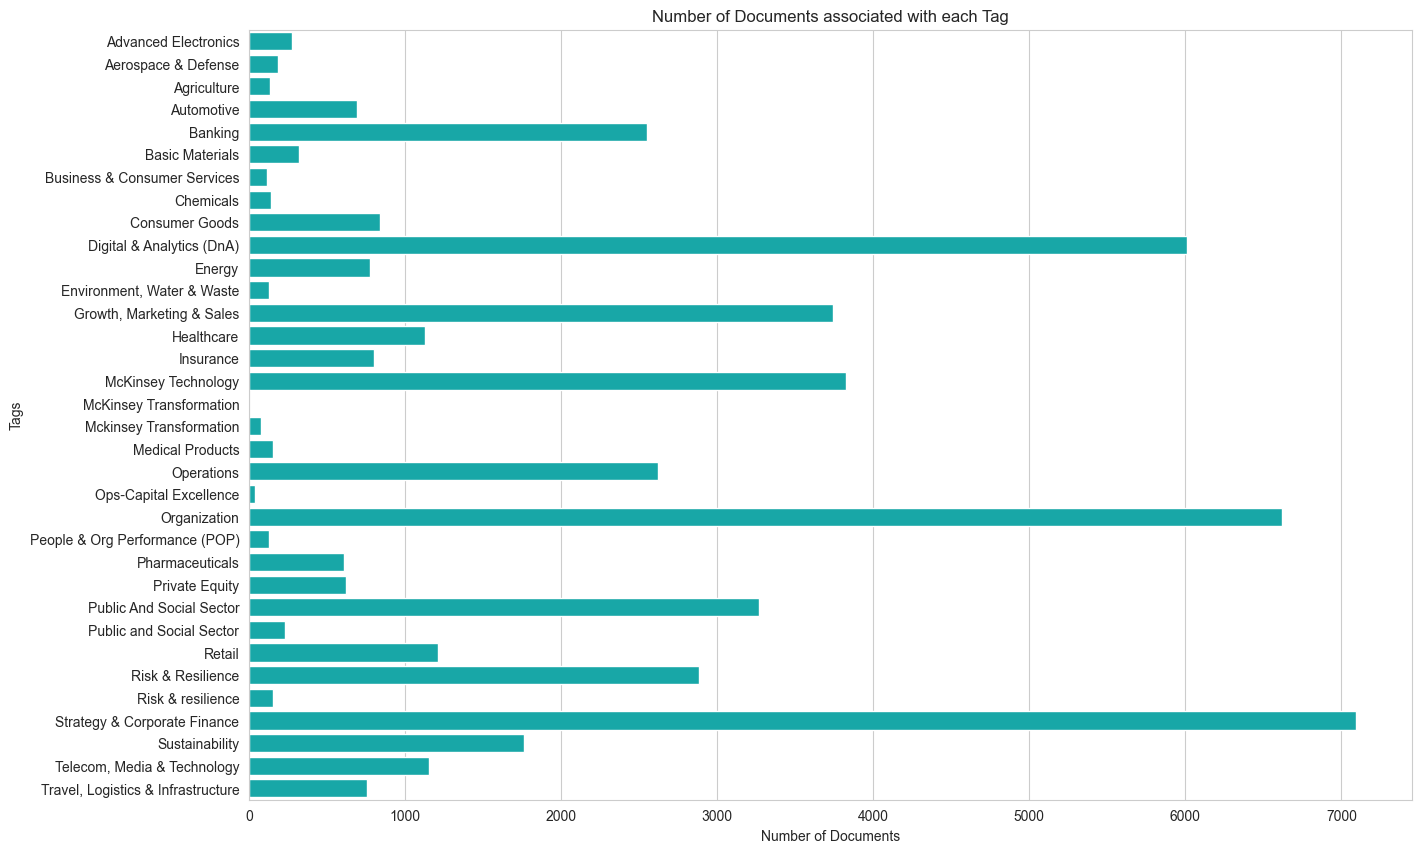

In [12]:
tag_counts = binarizedLabels1.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color='c')
plt.xlabel('Number of Documents')
plt.ylabel('Tags')
plt.title('Number of Documents associated with each Tag')
plt.show()

Train Test Split

In [13]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(dataset['SUMMARY'], binarizedLabels1, test_size=0.1,
                                                            random_state=41)

Text Vectorization

In [14]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
X_train_tfidf_1.shape, X_test_tfidf_1.shape

((18000, 506821), (2000, 506821))

### Model Training

Random Forest Classifier

In [15]:
RFC_1 = OneVsRestClassifier(RandomForestClassifier())
rfc1 = RFC_1.fit(X_train_tfidf_1, y_train_1)

Stochastic Gradient Descent Classifier

In [16]:
SGD_1 = OneVsRestClassifier(SGDClassifier())
sgd1 = SGD_1.fit(X_train_tfidf_1, y_train_1)

Logistic Regression

In [17]:
LR_1 = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
lr1 = LR_1.fit(X_train_tfidf_1, y_train_1)

Support Vector Classifier

In [18]:
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)

XGBoost Classifier

In [19]:
XGB_1 = OneVsRestClassifier(XGBClassifier())
xgb1 = XGB_1.fit(X_train_tfidf_1, y_train_1)

Ensemble Learning

In [46]:
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma='auto', probability=True)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('xgb', xgb_clf)], voting='hard')
ovr_voting_1 = OneVsRestClassifier(voting_clf)
ovr_voting_1.fit(X_train_tfidf_1, y_train_1)

KeyboardInterrupt: 

In [40]:
def jaccard_scr(y_true, y_pred, average_option='samples'):
    return jaccard_score(y_true, y_pred, average=average_option)

In [41]:
models = [
    ('RandomForest', rfc1),
    ('SGD', sgd1),
    ('LogisticRegression', lr1),
    ('LinearSVC', svc1),
    ('XGBoost', xgb1),
    # ('VotingClassifier', ovr_voting_1)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)

    accuracy = accuracy_score(y_test_1, predictions)
    precision = precision_score(y_test_1, predictions, average='samples', zero_division=0)
    recall = recall_score(y_test_1, predictions, average='samples', zero_division=0)
    f1 = f1_score(y_test_1, predictions, average='samples', zero_division=0)
    hamming_loss_value = hamming_loss(y_test_1, predictions)

    jaccard = jaccard_scr(y_test_1, predictions)

    model_comparison[model_name] = {'Jaccard Score': jaccard, 'Accuracy': accuracy * 100, 'Precision': precision,
                                    'Recall': recall, 'F1 Score': f1, 'Hamming Loss': hamming_loss_value}

    joblib.dump(model, model_name + '.joblib')

model_scores = pd.DataFrame.from_dict(model_comparison, orient='index')

model_scores

,Jaccard Score,Accuracy,Precision,Recall,F1 Score,Hamming Loss
RandomForest,0.302651,13.05,0.527542,0.316024,0.369294,0.058574
SGD,0.429949,18.45,0.692125,0.465142,0.520090,0.051985
LogisticRegression,0.357001,15.05,0.592250,0.384295,0.435583,0.057059
LinearSVC,0.493765,20.10,0.719525,0.568640,0.594537,0.049868
XGBoost,0.493593,18.15,0.678217,0.608319,0.599213,0.052926


#### Classification

In [22]:
text = [
    'Understanding mobility’s second great inflection point - Senior partner Asutosh Padhi discusses the technological breakthroughs changing the mobility ecosystem and lays out what the shifts mean for automotive and other industries.']
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc1.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Automotive', 'Insurance', 'Organization', 'Strategy & Corporate Finance')]

In [23]:
model = joblib.load('LinearSVC.joblib')

In [24]:
for i in X_test_1:
    text = pd.Series(i)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = model.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    print(predicted_labels)

[('Digital & Analytics (DnA)',)]
[('Public And Social Sector', 'Sustainability')]
[('Consumer Goods', 'Growth, Marketing & Sales', 'Retail')]
[('Healthcare', 'Strategy & Corporate Finance')]
[('Digital & Analytics (DnA)',)]
[('Operations', 'Strategy & Corporate Finance')]
[('Private Equity',)]
[('Banking', 'Strategy & Corporate Finance')]
[('Risk & Resilience', 'Strategy & Corporate Finance')]
[('Insurance', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Digital & Analytics (DnA)',)]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[()]
[('Telecom, Media & Technology',)]
[('Strategy & Corporate Finance',)]
[('Banking', 'Risk & Resilience')]
[('Organization',)]
[('Insurance', 'Risk & Resilience', 'Sustainability')]
[('Growth, Marketing & Sales', 'Retail', 'Telecom, Media & Technology')]
[('Digital & Analytics (DnA)', 'Growth, Marketing & Sales')]
[('Growth, Marketing & Sales', 'Retail')]
[('Growth, Marketing & Sales',)]
[('Digital & Analytics (DnA)', 'Energy', 'Operations

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras import Input

num_features = X_train_tfidf_1.shape[1]
num_classes = y_train_1.shape[1]
num_features, num_classes

model = Sequential()
model.add(Input(shape=(num_features)))
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

num_features = X_train_tfidf_1.shape[1]
num_classes = y_train_1.shape[1]

model = Sequential()
model.add(Input(shape=(num_features,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

In [78]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
# Train the model
history = model.fit(X_train_tfidf_1, y_train_1, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\Rituraj.Raman\Desktop\AIRA Project\AutoTagger\venv\Lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 129746176 elements. This may consume a large amount of memory.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 387s 856ms/step - accuracy: 0.0814 - loss: 0.3192 - val_accuracy: 0.2500 - val_loss: 0.1875
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 381s 846ms/step - accuracy: 0.3482 - loss: 0.1426 - val_accuracy: 0.3650 - val_loss: 0.1634
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 383s 850ms/step - accuracy: 0.4502 - loss: 0.0574 - val_accuracy: 0.3944 - val_loss: 0.1898
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 377s 837ms/step - accuracy: 0.4796 - loss: 0.0250 - val_accuracy: 0.3981 - val_loss: 0.2497
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 380s 844ms/step - accuracy: 0.5087 - loss: 0.0129 - val_accuracy: 0.3606 - val_loss: 0.3025
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 378s 840ms/step - accuracy: 0.5079 - loss: 0.0080 - val_accuracy: 0.3706 - val_loss: 0.3140
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 388s 861ms/step - accuracy: 0.5113 - loss: 0.0046 - val_accuracy: 0.3594 - val_loss: 0.3629
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 378s 839ms/step - accuracy: 0.5082 - loss: 0.00

In [80]:
# Save the Model
model.save('nnmodel.keras')

In [74]:
# Predicting the tags
score = model.evaluate(X_train_tfidf_1, y_train_1, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test_tfidf_1)
y_pred = y_pred.argmax(axis=1)

Test loss: 0.0723656564950943
Test accuracy: 0.5046111345291138
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([25, 31, 12, ..., 21, 30,  4], dtype=int64)

In [75]:
predictions = model.predict(X_test_tfidf_1)
threshold = 0.4
binary_predictions = (predictions > threshold).astype(int)
binary_predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [76]:
predicted_labels = mlb.inverse_transform(binary_predictions)
predicted_labels

[(),
 ('Sustainability',),
 ('Growth, Marketing & Sales', 'Retail'),
 (),
 ('Digital & Analytics (DnA)',),
 ('Operations',),
 (),
 (),
 ('Strategy & Corporate Finance',),
 (),
 ('Organization',),
 (),
 ('Digital & Analytics (DnA)', 'McKinsey Technology'),
 (),
 (),
 (),
 ('Risk & Resilience',),
 ('Organization',),
 ('Risk & Resilience',),
 ('Growth, Marketing & Sales',),
 ('Growth, Marketing & Sales',),
 ('Growth, Marketing & Sales', 'Retail'),
 (),
 (),
 ('Automotive',),
 ('Public And Social Sector',),
 (),
 (),
 ('Banking',),
 (),
 ('Growth, Marketing & Sales', 'Telecom, Media & Technology'),
 ('Organization',),
 (),
 (),
 ('Digital & Analytics (DnA)',),
 (),
 ('Strategy & Corporate Finance',),
 (),
 (),
 ('Banking',),
 ('Growth, Marketing & Sales',),
 (),
 ('Digital & Analytics (DnA)',),
 (),
 ('Digital & Analytics (DnA)',),
 (),
 (),
 ('Organization', 'Public And Social Sector'),
 ('Growth, Marketing & Sales',),
 ('Growth, Marketing & Sales', 'Retail'),
 (),
 (),
 (),
 ('Organizati

### 2nd Label Prediction

In [25]:
mlb = MultiLabelBinarizer()
binarizedLabels2 = mlb.fit_transform(dataset['SL/SUB-AREA'])
binarizedLabels2 = pd.DataFrame(binarizedLabels2, columns=mlb.classes_)
binarizedLabels2.head()

,Accounting services,Advanced Electronics- Other,Advanced materials,Aerospace & Defense- Other,Aerospace aftermarket & services,Aerospace equipment & products,Aftermarket & services,Agricultural inputs,Agricultural produce trading & processing,Agriculture input distribution & service,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
dataset = pd.concat([dataset, binarizedLabels2], axis=1)
dataset.drop('SL/SUB-AREA', axis=1, inplace=True)
dataset.head()

,SUMMARY,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,urban ocean risk study qualitatively semicondu...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,would concerned result faster view comprehensi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,supply widespread adjust work covid life broug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,fight vaccine normal sight next define trend e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,global report entirely reality quickly opportu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


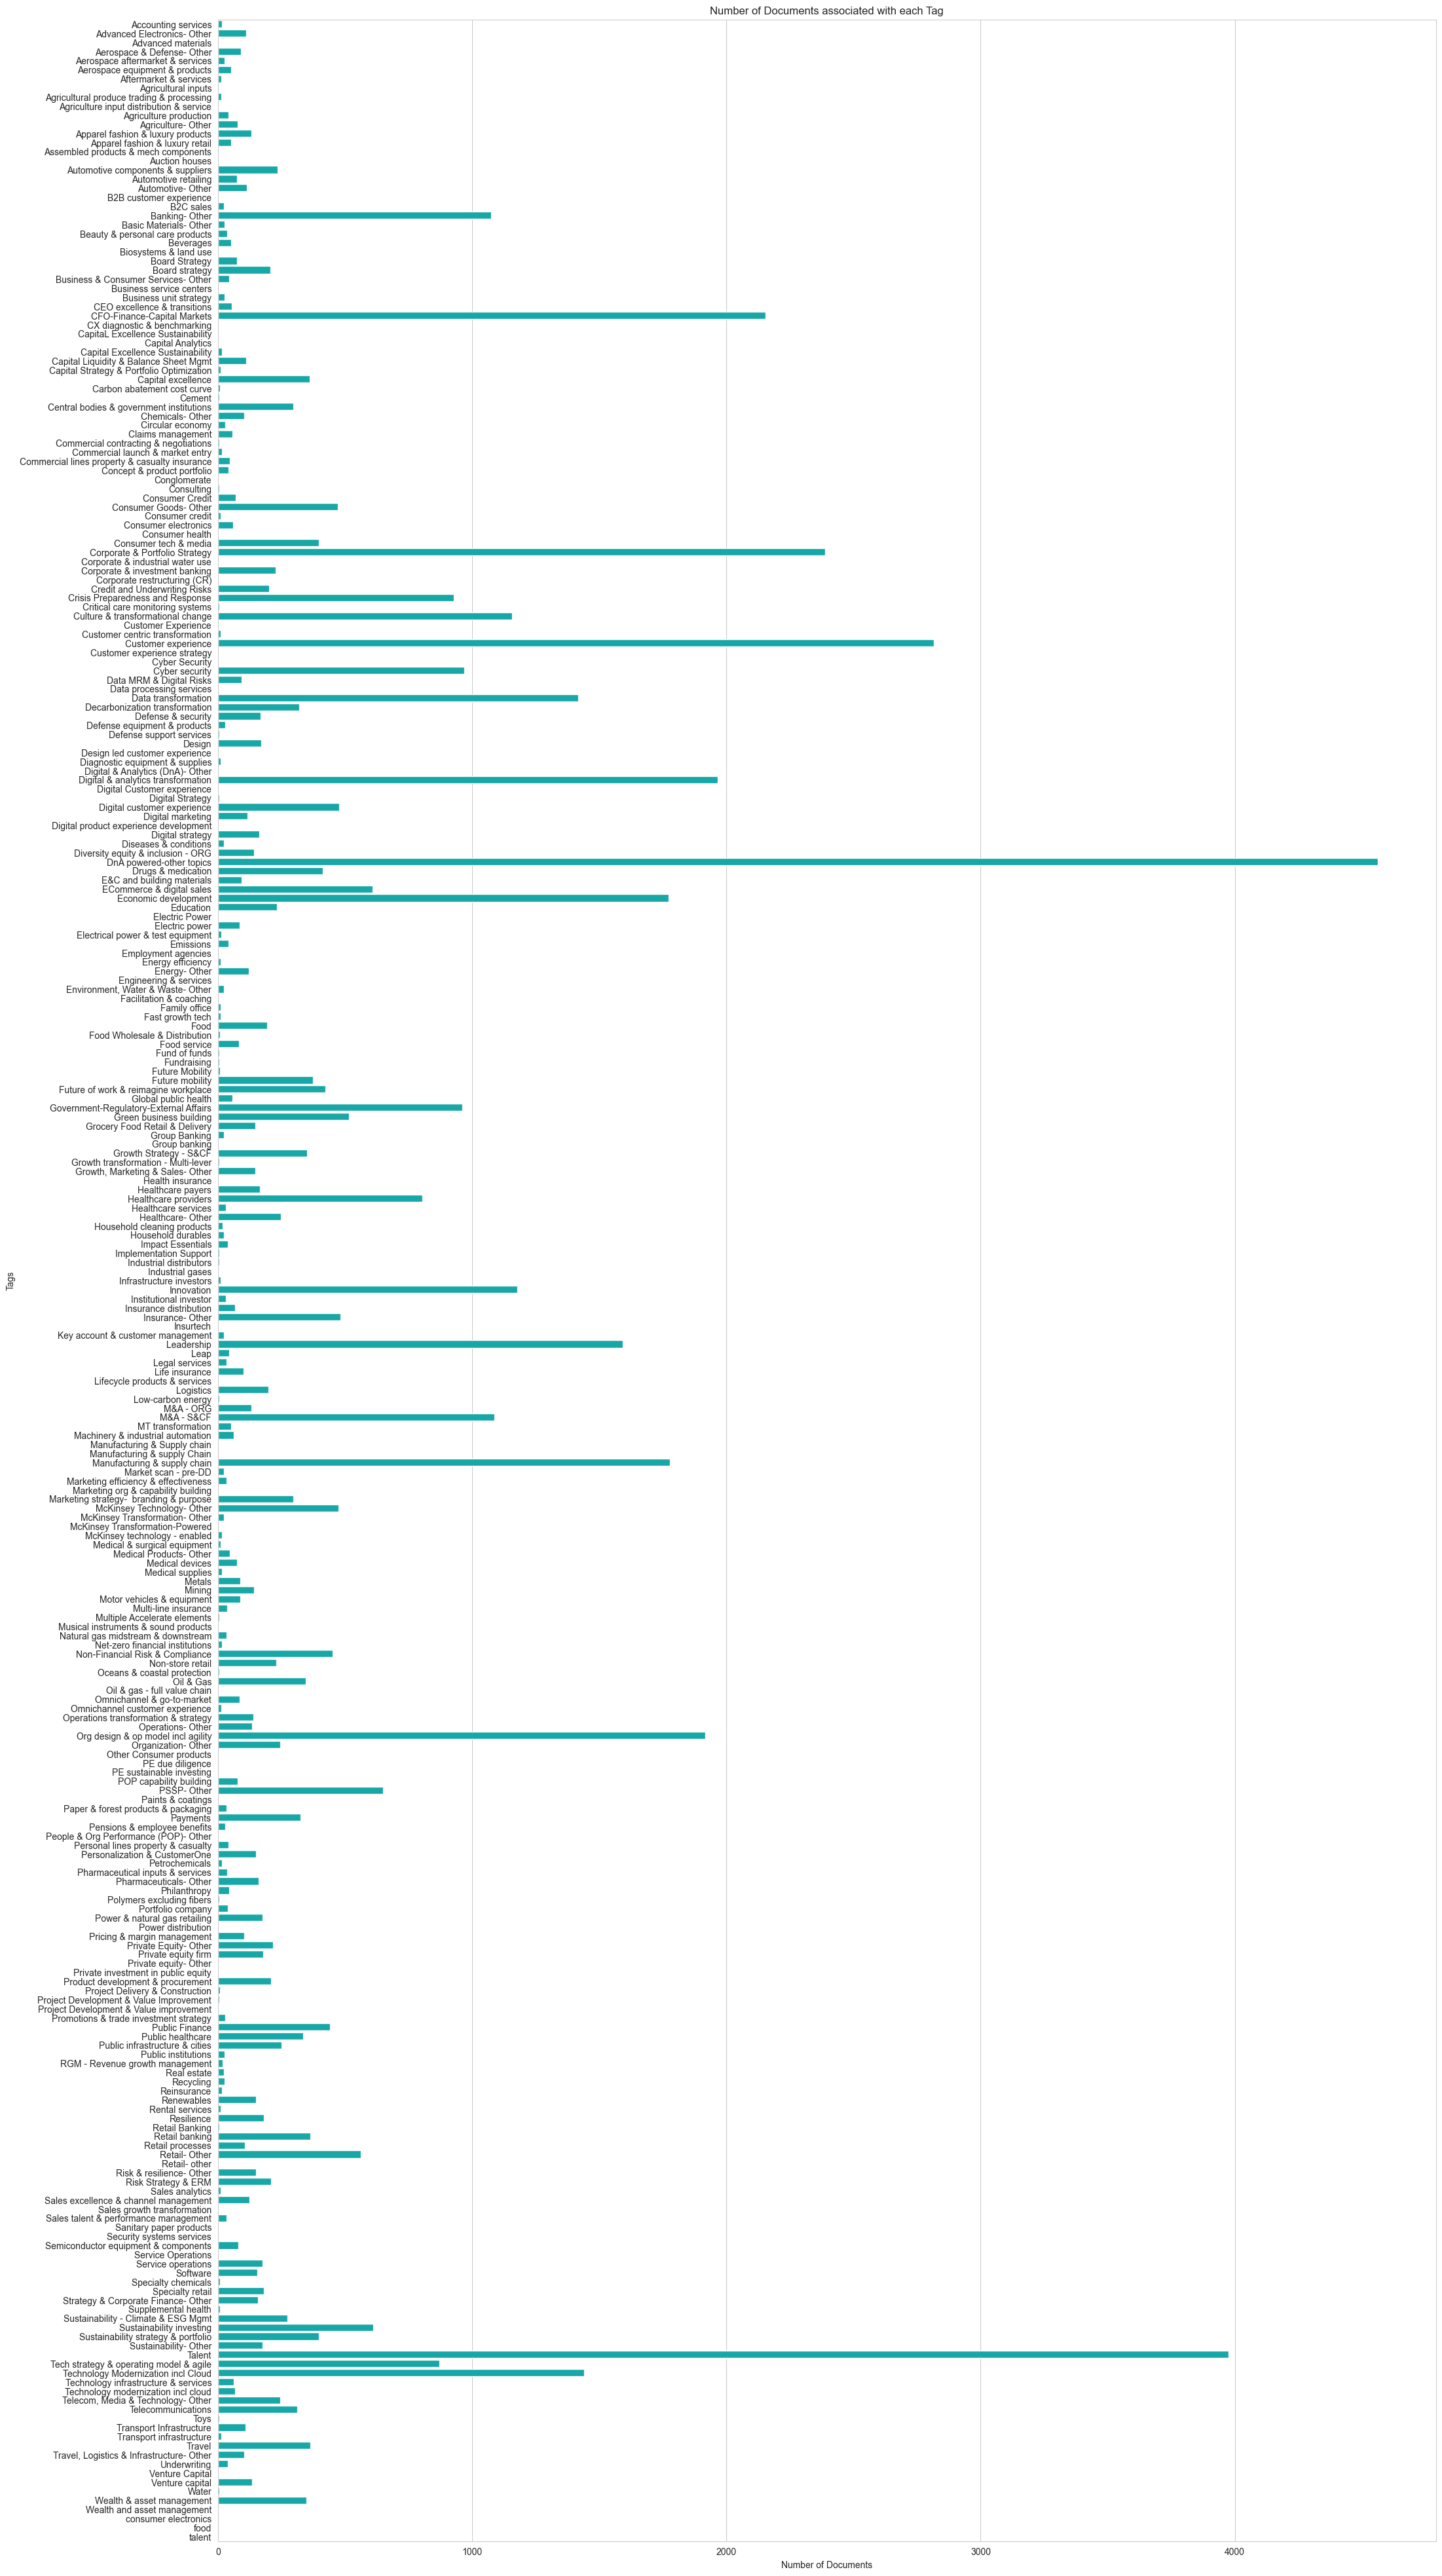

In [27]:
# Calculate the sum of each tag column
tag_counts = binarizedLabels2.sum(numeric_only=True)

# Plot
plt.figure(figsize=(24, 50))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color='c')
plt.xlabel('Number of Documents')
plt.ylabel('Tags')
plt.title('Number of Documents associated with each Tag')
plt.show()

In [28]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dataset['SUMMARY'], binarizedLabels2, test_size=0.1,
                                                            random_state=41)

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf_2 = tfidf.fit_transform(X_train_2)
X_test_tfidf_2 = tfidf.transform(X_test_2)
X_train_tfidf_2.shape, X_test_tfidf_2.shape

((18000, 506821), (2000, 506821))

Random Forest Classifier

In [30]:
RFC_2 = OneVsRestClassifier(RandomForestClassifier())
rfc2 = RFC_2.fit(X_train_tfidf_2, y_train_2)

Stochastic Gradient Descent Classifier

In [31]:
SGD_2 = OneVsRestClassifier(SGDClassifier())
sgd2 = SGD_2.fit(X_train_tfidf_2, y_train_2)

Logistic Regression

In [32]:
LR_2 = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
lr2 = LR_2.fit(X_train_tfidf_2, y_train_2)

Support Vector Classifier

In [33]:
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_2, y_train_2)

XGBoost Classifier

In [34]:
XGB_2 = OneVsRestClassifier(XGBClassifier())
xgb2 = XGB_2.fit(X_train_tfidf_2, y_train_2)

Ensemble Learning

In [ ]:
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma='auto', probability=True)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('xgb', xgb_clf)], voting='hard')
ovr_voting_2 = OneVsRestClassifier(voting_clf)
ovr_voting_2.fit(X_train_tfidf_2, y_train_2)

In [35]:
models = [
    ('RandomForest', rfc2),
    ('SGD', sgd2),
    ('LogisticRegression', lr2),
    ('LinearSVC', svc2),
    ('XGBoost', xgb2),
    # ('VotingClassifier', ovr_voting_2)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_2)

accuracy = accuracy_score(y_test_2, predictions)
precision = precision_score(y_test_2, predictions, average='samples', zero_division=0)
recall = recall_score(y_test_2, predictions, average='samples', zero_division=0)
f1 = f1_score(y_test_2, predictions, average='samples', zero_division=0)
hamming_loss_value = hamming_loss(y_test_2, predictions)

jaccard = jaccard_scr(y_test_2, predictions)

model_comparison[model_name] = {'Jaccard Score': jaccard, 'Accuracy': accuracy * 100, 'Precision': precision,
                                'Recall': recall, 'F1 Score': f1, 'Hamming Loss': hamming_loss_value}

joblib.dump(model, model_name + '2.joblib')

model_scores = pd.DataFrame.from_dict(model_comparison, orient='index')

model_scores

,Jaccard Score,Accuracy,Precision,Recall,F1 Score,Hamming Loss
RandomForest,8.607926,3.20,0.174813,0.088170,0.108686,0.010421
SGD,15.700442,4.90,0.341542,0.161330,0.203967,0.009966
LogisticRegression,11.685322,3.45,0.265500,0.119584,0.153369,0.010260
LinearSVC,25.692062,7.90,0.492771,0.281045,0.330289,0.009505
XGBoost,30.691398,8.15,0.524682,0.378002,0.400534,0.010235


In [36]:
text = [
    'Understanding mobility’s second great inflection point - Senior partner Asutosh Padhi discusses the technological breakthroughs changing the mobility ecosystem and lays out what the shifts mean for automotive and other industries.']
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc2.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Automotive- Other',
  'Culture & transformational change',
  'Government-Regulatory-External Affairs',
  'Personal lines property & casualty')]

In [38]:
for i in X_test_2:
    text = pd.Series(i)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = xgb2.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
print(predicted_labels)

[()]
[('Decarbonization transformation', 'Green business building', 'Sustainability - Climate & ESG Mgmt', 'Sustainability strategy & portfolio')]
[('Customer experience', 'Marketing strategy-  branding & purpose')]
[('Healthcare payers', 'M&A - S&CF')]
[('Technology modernization incl cloud',)]
[('Manufacturing & supply chain',)]
[('Venture capital',)]
[('Banking- Other',)]
[('Board strategy',)]
[('DnA powered-other topics', 'Growth Strategy - S&CF', 'Insurance distribution')]
[()]
[('Wealth & asset management',)]
[('Digital & analytics transformation', 'DnA powered-other topics', 'Oil & Gas', 'Org design & op model incl agility')]
[('Public infrastructure & cities',)]
[('Consumer tech & media', 'Customer experience', 'Digital marketing')]
[()]
[('Banking- Other', 'Wealth & asset management')]
[('Talent',)]
[('Cyber security', 'Insurance- Other', 'Sustainability - Climate & ESG Mgmt')]
[('Consumer tech & media', 'Customer experience', 'Retail- Other')]
[('Customer experience', 'Digita

KeyboardInterrupt: 